In [2]:
import numpy as np
import cv2 as cv
import glob
from scipy.spatial.transform import Rotation as R

In [3]:
mtx = np.array(
  [[761.81488037, 0.0, 646.52478027], 
   [0.0, 761.15325928, 361.41662598], 
   [0.0, 0.0, 1.0]]
)
dist = np.array(
  [7.613864421844482, 17.2153263092041, 0.00012345814320724458, -0.00020271474204491824, -1.0174853801727295, 7.641190528869629, 19.72230339050293, 1.2936210632324219, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
)
board_size = (8,6)
square_size = 0.025

In [4]:
def draw(img, corners, imgpts):
  # breakpoint()
  corner = tuple(corners[0].ravel())
  x_axis = tuple(imgpts[0].ravel())
  y_axis = tuple(imgpts[1].ravel())
  z_axis = tuple(imgpts[2].ravel())
  img = cv.line(img, (int(corner[0]), int(corner[1])), (int(x_axis[0]), int(x_axis[1])), (255,0,0), 5)
  img = cv.line(img, (int(corner[0]), int(corner[1])), (int(y_axis[0]), int(y_axis[1])), (0,255,0), 5)
  img = cv.line(img, (int(corner[0]), int(corner[1])), (int(z_axis[0]), int(z_axis[1])), (0,0,255), 5)
  return img

In [5]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((board_size[0]*board_size[1],3), np.float32)
objp[:,:2] = np.mgrid[0:board_size[0],0:board_size[1]].T.reshape(-1,2)
# From checkerboard unit to meters
objp = objp*square_size
axis = np.float32([[3*square_size,0,0], [0,3*square_size,0], [0,0,-3*square_size]]).reshape(-1,3)


In [6]:
fname = "checkboard-1.jpg"

In [7]:
img = cv.imread(fname)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
ret, corners = cv.findChessboardCorners(gray, (board_size[0],board_size[1]),None)

if ret == True:
  corners2 = cv.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)

# Find the rotation and translation vectors.
ret,rvecs, tvecs = cv.solvePnP(objp, corners2, mtx, dist)
# breakpoint()
orientation_cam2chess = R.from_rotvec(rvecs.reshape((3,)))

print(f"Rotation_matrix: camera_optical2chess")
print(f"{orientation_cam2chess.as_matrix()}")
print(f"Translation_vectors: camera_optical2chess")
print(f"{tvecs}\n")

# project 3D points to image plane
imgpts, jac = cv.projectPoints(axis, rvecs, tvecs, mtx, dist)
# breakpoint()
img = draw(img,corners2,imgpts)

Rotation_matrix: camera_optical2chess
[[-0.0081793   0.99806148  0.06169588]
 [-0.96624674  0.00799861 -0.25749421]
 [-0.25748853 -0.06171956  0.96430822]]
Translation_vectors: camera_optical2chess
[[-0.03070022]
 [ 0.04624395]
 [ 0.59684292]]



In [8]:
projection_cam2chess = np.eye(4)
projection_cam2chess[:3, :3] = orientation_cam2chess.as_matrix()
projection_cam2chess[:3, 3] = tvecs.reshape((3,))

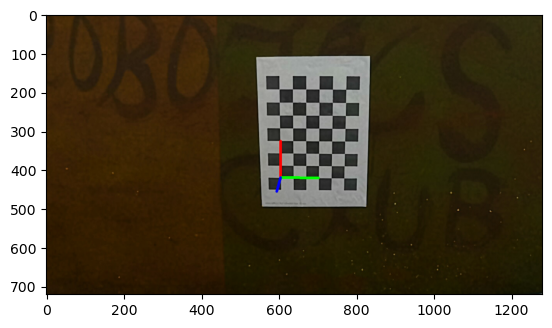

In [9]:
from PIL import Image
from matplotlib.pyplot import imshow
import numpy as np

%matplotlib inline

imshow(np.asarray(img))

In [10]:
from numpy import pi

t_base2chess = np.array(
  [1.0, 0.05, 0.3]
)
ypr_base2chess = np.array(
  [0, -pi/2, pi]
)
orientation_base2chess = R.from_euler('ZYX', ypr_base2chess)

In [11]:
projection_base2chess = np.eye(4)
projection_base2chess[:3,:3] = orientation_base2chess.as_matrix()
projection_base2chess[:3, 3] = t_base2chess

In [12]:
print("Rotation: base2chess")
print(f"{orientation_base2chess.as_matrix()}")
print("Translation: base2chess")
print(f"{t_base2chess}")

Rotation: base2chess
[[ 2.22044605e-16 -1.22464680e-16  1.00000000e+00]
 [ 0.00000000e+00 -1.00000000e+00 -1.22464680e-16]
 [ 1.00000000e+00  2.46519033e-32 -2.22044605e-16]]
Translation: base2chess
[1.   0.05 0.3 ]


In [13]:
R_base2cam = orientation_base2chess.as_matrix() @ np.linalg.inv(orientation_cam2chess.as_matrix())
t_base2cam = t_base2chess - tvecs.reshape((3,))

In [14]:
print(tvecs.reshape((3,)))

[-0.03070022  0.04624395  0.59684292]


In [15]:
print("Rotation: base2cam")
print(f"{R_base2cam}")
print("Translation: base2cam")
print(f"{t_base2cam}")

Rotation: base2cam
[[ 0.06169588 -0.25749421  0.96430822]
 [-0.99806148 -0.00799861  0.06171956]
 [-0.0081793  -0.96624674 -0.25748853]]
Translation: base2cam
[ 1.03070022  0.00375605 -0.29684292]


In [16]:
projection_base2cam = projection_base2chess @ np.linalg.inv(projection_cam2chess)

In [17]:
print("Projection matrix: base2cam")
print(projection_base2cam)

Projection matrix: base2cam
[[ 0.06169588 -0.25749421  0.96430822  0.43826109]
 [-0.99806148 -0.00799861  0.06171956 -0.0171077 ]
 [-0.0081793  -0.96624674 -0.25748853  0.49811217]
 [ 0.          0.          0.          1.        ]]
